In [1]:
from IPython.core.display import HTML
css_file = './custom.css'
HTML(open(css_file, "r").read())

###### Content provided under a Creative Commons Attribution license, CC-BY 4.0; code under MIT License. (c)2015 [David I. Ketcheson](http://davidketcheson.info)

##### Version 0.1 - April 2015

# Pseudospectral methods for wave equations in Python 

Welcome to PseudoSpectralPython, a short course that will teach you how to solve wave equations using pseudospectral collocation methods.  This notebook is the first lesson, on solving linear problems.

###Table of contents:

- [Advection-diffusion](#Advection-diffusion)
- [Approximate solution](#Approximate-solution-by-discrete-Fourier-transforms)
- [General linear PDEs](#General-linear-evolution-PDEs)

## Advection-diffusion
Let's get started!  Run the code cell below to import a bunch of Python libraries we'll use.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from JSAnimation import IPython_display

To begin, let's consider the partial differential equation (PDE)

$$u_t + a u_x = \epsilon u_{xx}$$

referred to as the *advection-diffusion* equation, for reasons we'll soon discover.  Here we wish to find $u(x,t)$, and the subscripts denote partial differentiation; e.g. $u_t$ is the partial derivative of $u$ with respect to $t$.  The coefficients $a$ and $\epsilon$ are constants that determine the strength of the advective and diffusive effects.

###Exact solution by Fourier analysis
Let's solve this equation on a periodic domain $[-\pi,\pi]$, with some initial data

$$u(x,0) = u_0(x).$$

If we suppose for a moment that our solution is composed of a single Fourier mode with wavenumber $\xi$ and time-dependent amplitude $\hat{u}$:

$$u(x,t; \xi) = \hat{u}(t) e^{i\xi x},$$

Then we obtain a simple ordinary differential equation (ODE) for $\hat{u}$:

$$\hat{u}'(t; \xi) + i\xi a \hat{u} = -\xi^2 \epsilon \hat{u}$$

We can solve this scalar ODE exactly:

$$\hat{u}'(t; \xi) = e^{(-i \xi a - \epsilon \xi^2)t} \hat{u}(0).$$

We've transformed the original PDE into a simple ODE, but you may wonder whether this is useful, since we assumed a very simple form for the solution.  The marvelous fact is that every solution of this equation can be written as a linear combination (a *superposition*) of simple solutions of the form above, with different wavenumbers $\xi$.  We can construct the general solution as follows.

First, we take a Fourier transform of the initial data:

$$\hat{u}(t=0;\xi) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^\infty u_0(x) e^{-i\xi x}dx.$$

Then each mode evolves according to the solution of the ODE above:

$$\hat{u}'(t; \xi) = e^{(-i \xi a - \epsilon \xi^2)t} \hat{u}(0;\xi).$$

Finally, we construct the solution again by taking the inverse Fourier transform.  This just means summing up all the Fourier modes:

$$u(x,t) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^\infty u_0(x) e^{i\xi x}d\xi.$$

If you haven't seen Fourier analysis at all before, now is a good time to go read up a bit and then come back.

## Approximate solution by discrete Fourier transforms

We can evaluate the integrals above exactly on the computer (at least, not for arbitrary initial data $u_0$).  Instead, we need to **discretize**.  To do so, we introduce a grid with a finite set of points in space and time:

In [3]:
# Spatial grid
m=64                            # Number of grid points in space
L = 2 * np.pi                   # Width of spatial domain
x = np.arange(-m/2,m/2)*(L/m)   # Grid points
dx = x[1]-x[0]                  # Grid spacing

# Temporal grid
tmax=4.0     # Final time
N = 25       # number of times to show output
k = tmax/N   # time step size

and a corresponding set of discrete wavenumber values $\xi$:

In [4]:
xi=np.fft.fftfreq(m)*m/(L/(2*np.pi))  # Wavenumber "grid"
# (this is the order in which numpy's FFT gives the frequencies)

The functions $u, \hat{u}$ discussed above are be replaced by finite-dimensional vectors.  These vectors are related through the discrete version of the Fourier transform, aptly called the **discrete Fourier transform** (DFT).  We'll look at the DFT in more detail in the next lesson.  For now, let's set the initial condition to

$$u_0(x) = \begin{cases} \sin^2(2x) & -\pi \le x < -\pi/2 \\ 0 & x>-\pi/2 \end{cases}$$

and compute its DFT:

In [5]:
# Initial data
u = np.sin(2*x)**2 * (x<-L/4)
uhat0 = np.fft.fft(u)

Next, we set a value for epsilon and  compute the solution:

In [10]:
epsilon=0.01  # Diffusion coefficient
a = 1.0       # Advection coefficient

# Store solutions in a list for plotting later
frames = [u.copy()]


# Now we solve the problem
for n in range(1,N+1):
    t = n*k
    uhat = np.exp(-(1.j*xi*a + epsilon*xi**2)*t) * uhat0
    u = np.real(np.fft.ifft(uhat))
    frames.append(u.copy())

We have computed and stored the solution.  The code below plots it as an animation.


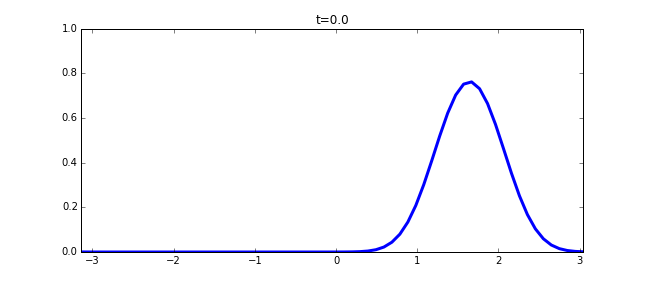
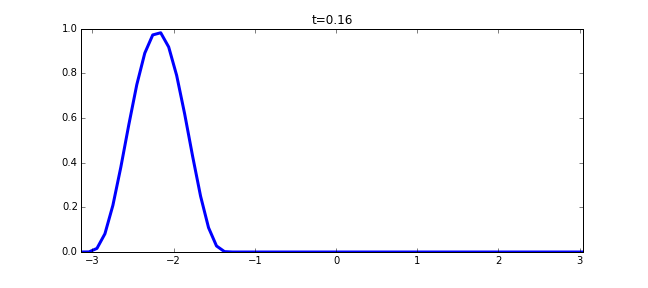
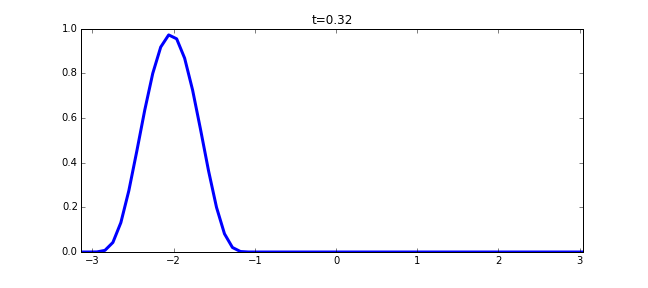
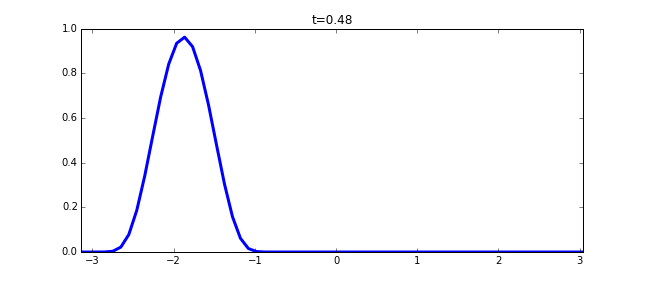
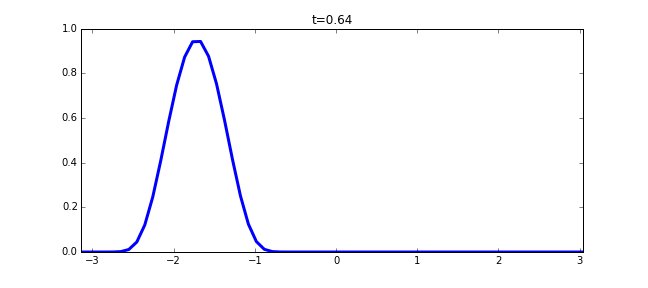
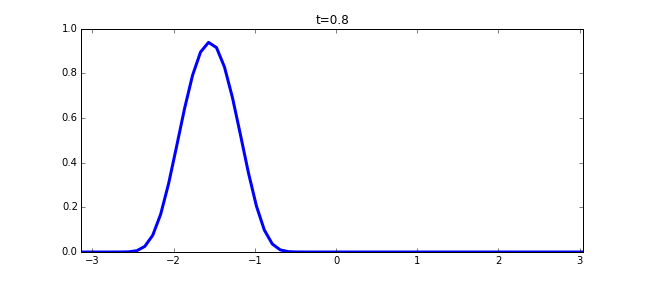
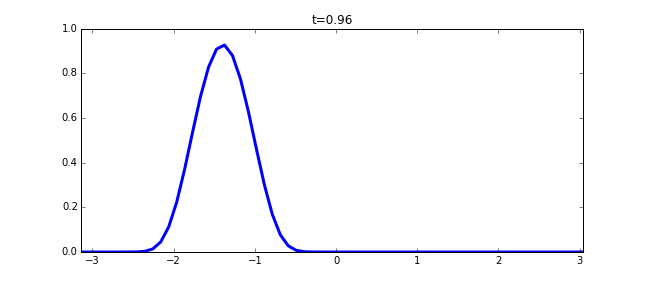
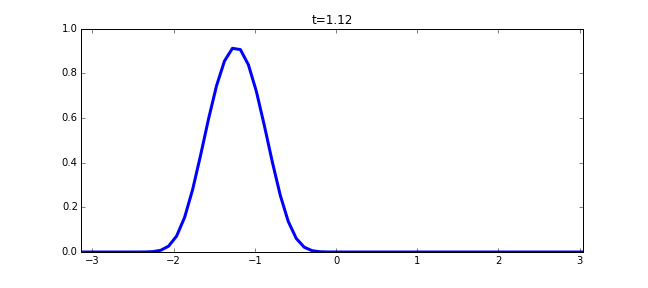
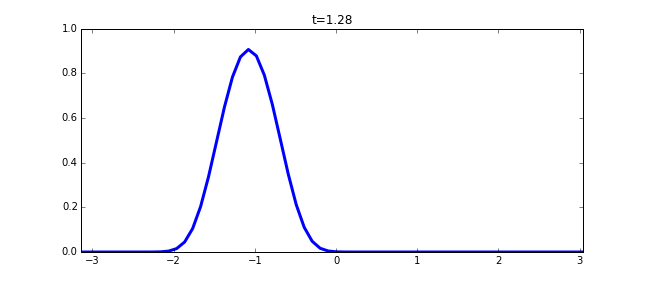
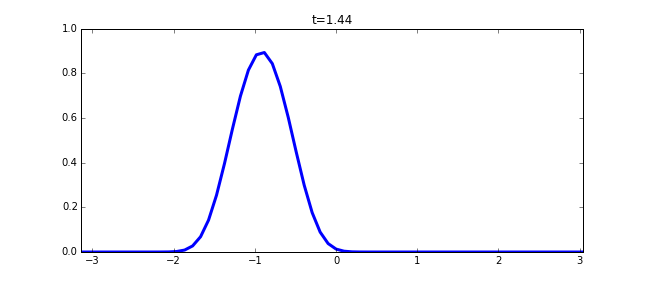
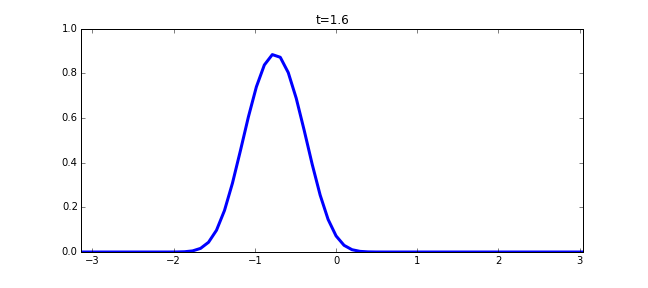
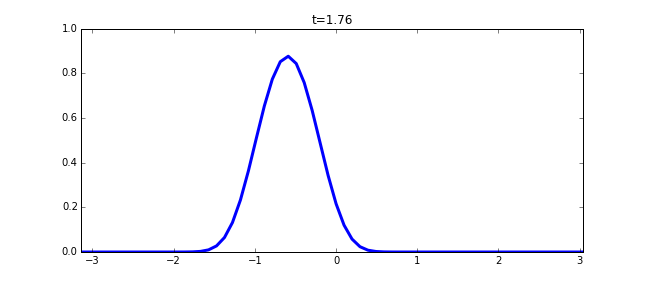
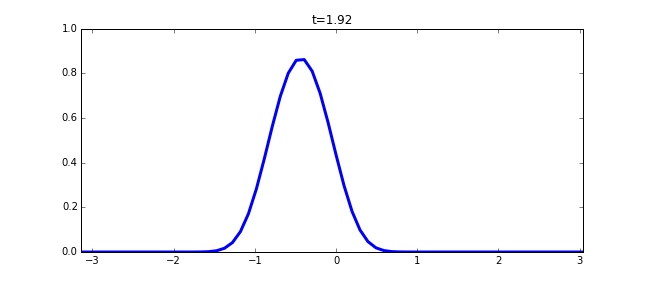
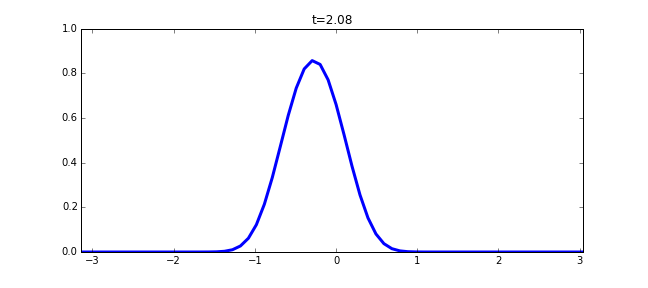
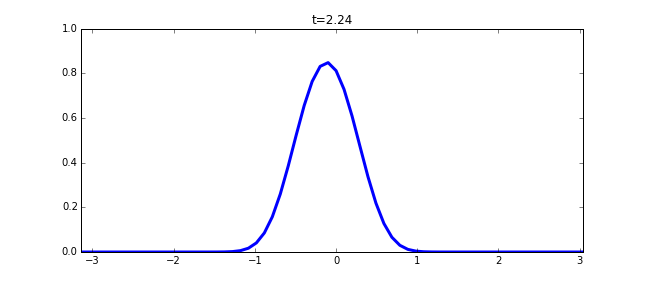
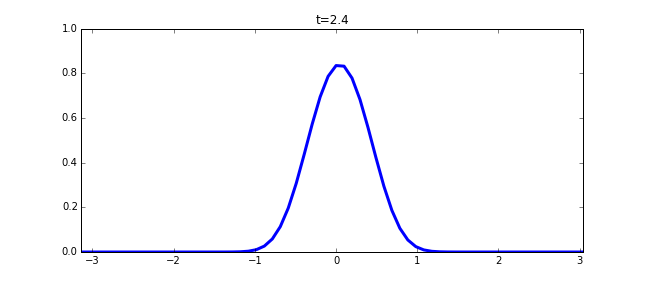
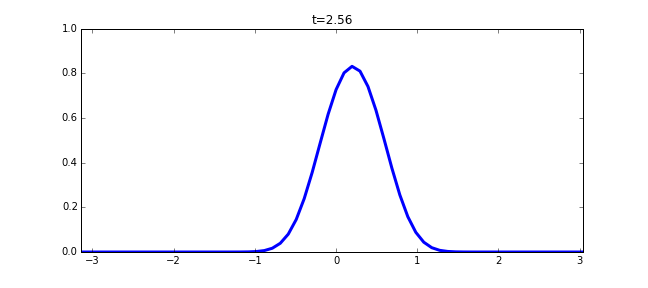
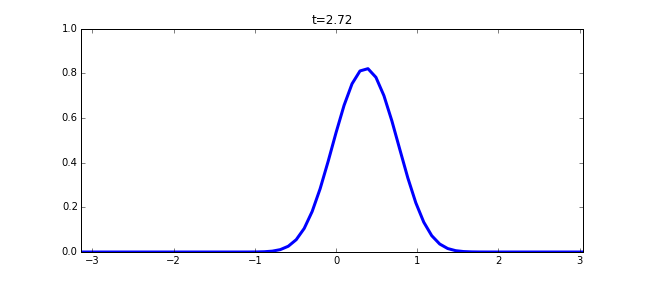
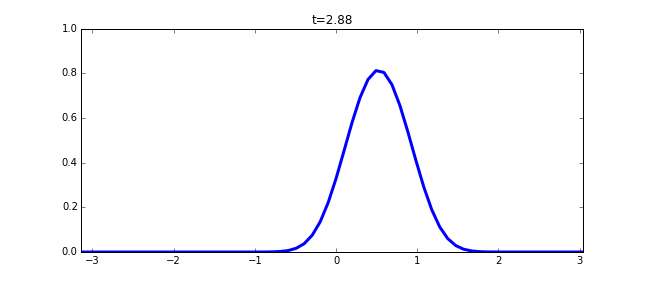
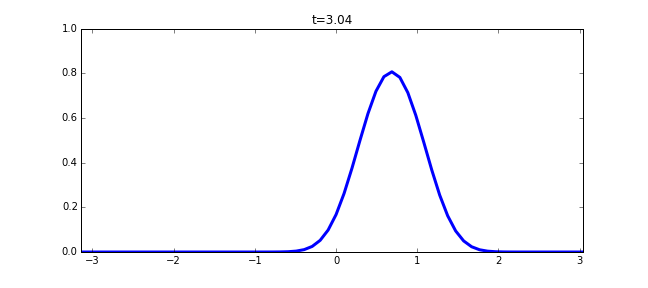
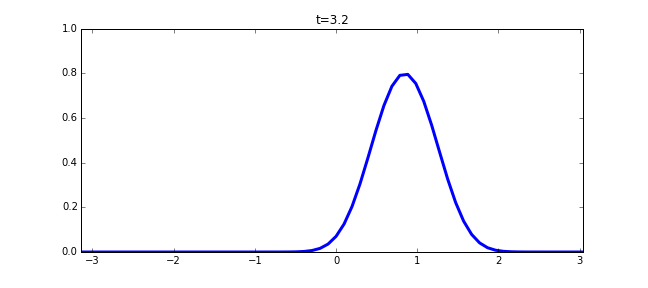
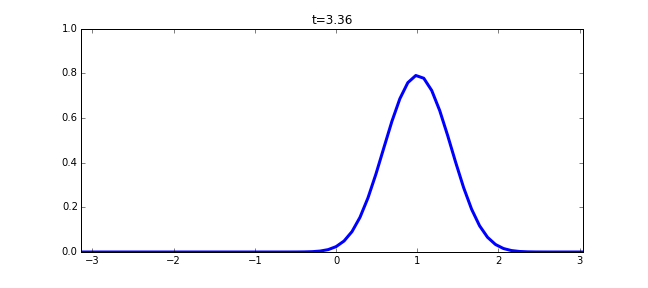
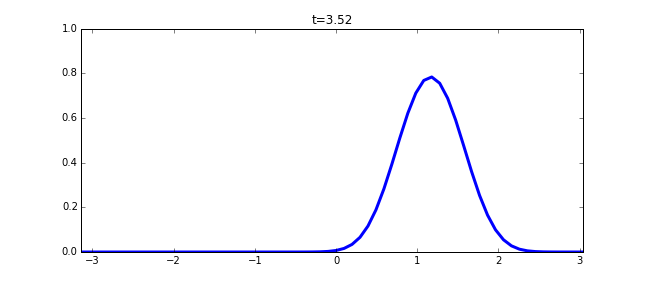
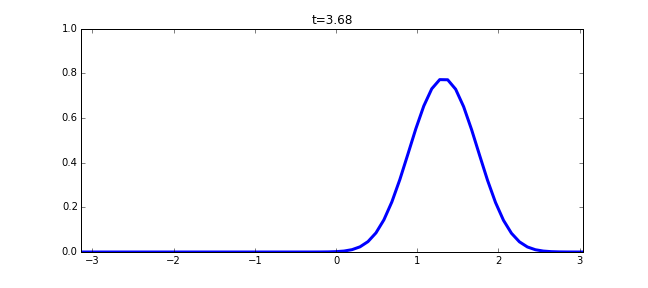
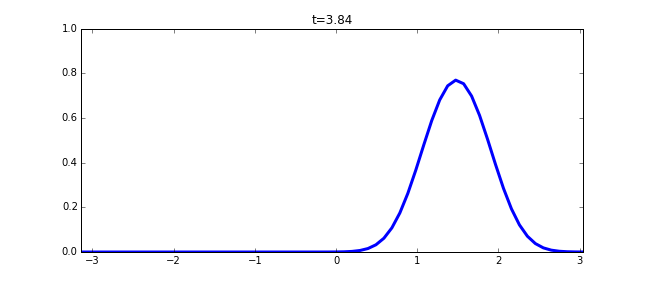
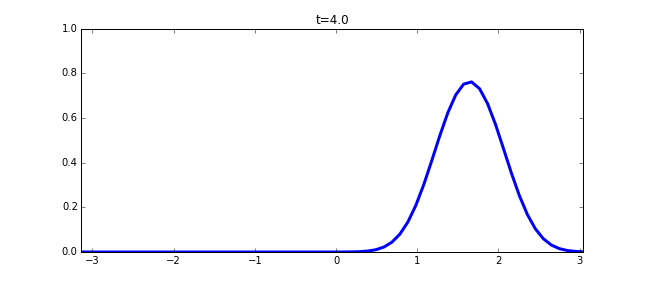

In [11]:
# Set up plotting
fig = plt.figure(figsize=(9,4)); axes = fig.add_subplot(111)
line, = axes.plot([],[],lw=3)
axes.set_xlim((x[0],x[-1])); axes.set_ylim((0.,1.))

def plot_frame(i):
    line.set_data(x,frames[i])
    axes.set_title('t='+str(i*k))

# Animate the solution
matplotlib.animation.FuncAnimation(fig, plot_frame,
                                   frames=len(frames),
                                   interval=200)

###Exercise
*Rerun the two cells above with different values of $a$ and $\epsilon$.  What does each of these coefficients do?*

## Review
What did we just do?  We solved a partial differential equation computationally.  It's time to think about how accurate the solution is and what approximations we made.

The first approximation we made was to take the initial data and approximate it by just the first terms in its Fourier series.  How many terms did we include?  The vector $\hat{u}$ we computed contains just the first 64 Fourier modes (because we chose to use 64 points in our spatial grid vector $x$).

What about the evolution in time?  In fact, our time evolution of the solution is **exact** for the initial data vector, since it just uses the exact solution formula for the ODE that we derived above.

In plotting the solution, note that we only used the values at the 64 spatial grid points.  The `plot()` function merely connects these values by straight lines.  We could plot a better representation of the solution by evaluating the Fourier series on a finer grid, but for now we won't worry about that.

## General linear evolution PDEs

The approach we just described isn't particular to the advection-diffusion equation.  In fact, it can be used to solve any linear evolution PDE (including systems of PDEs, but here we'll stick to scalar problems):

$$u_t = \sum_j \alpha_j \frac{\partial^j u}{\partial x^j}.$$

*Should say something here about periodicity*

#Burgers' equation

Next, let's solve the viscous Burgers' equation:
$$u_t + uu_x = \epsilon u_{xx}.$$
This equation includes both a nonlinear term ($uu_x$) and a dissipative term ($u_{xx}$).

We'll use the Fourier transform again, but because of the nonlinear term we won't be able to integrate exactly in time.  Instead, we'll apply a *pseudospectral* method in space and a *Runge-Kutta* method in time.  The second-derivative term would make the problem stiff, but we'll avoid this with an integrating factor.

The nonlinear term causes steepening, which involves generation of high frequency modes.  For $\epsilon \ll 1$, the dissipative term only becomes important when the solution gets very steep; it prevents the formation of shock waves (discontinuities).

We can rewrite Burgers' equation as
$$
u_t + \frac{1}{2}(u^2)_x = \epsilon u_{xx}.
$$

Taking the Fourier transform, we replace each $x$-derivative by $i \xi$ and replace $u$ by it's Fourier transform $\hat{u}$:
$$
\hat{u}_t + \frac{i\xi}{2} \widehat{u^2} = -\xi^2 \epsilon \hat{u}.
$$
As discussed in class, the dissipative term (involving $\xi^2$) leads to stiffness.  However, we can get rid of it by multiplying everything by the *integrating factor* $\exp(\xi^2 \epsilon t)$.  This gives
$$
e^{\xi^2 \epsilon t} \hat{u}_t + \frac{i\xi}{2} e^{\xi^2 \epsilon t} \widehat{u^2} = -\xi^2 \epsilon e^{\xi^2 \epsilon t}\hat{u}.
$$
Next we define $\hat{U} = e^{\xi^2 \epsilon t} \hat{u}$.  Then $\hat{U}_t = \xi^2 \epsilon \hat{U} + e^{\xi^2 \epsilon t} \hat{u}_t$.  So we get
$$
\hat{U}_t - \xi^2 \epsilon \hat{U}  + \frac{i\xi}{2} e^{\xi^2 \epsilon t} \widehat{u^2} = -\xi^2 \epsilon \hat{U}.
$$
Now the stiff terms cancel, leaving
$$
\hat{U}_t  + \frac{i\xi}{2} e^{\xi^2 \epsilon t} \widehat{u^2} = 0.
$$
We can view this as a semi-discretization of the original PDE, but in the frequency domain.  We'll solve the problem in the frequency domain, but in order to evaluate the nonlinear term $\widehat{u^2}$, we'll use the technique of *pseudospectral collocation*.  That means that we'll Fourier transform back to the spatial domain, compute $u^2$, and then transform back to the frequency domain.  The semi-discretization then looks like this:
$$
\hat{U}'(t) = - \frac{i\xi}{2} \exp \left( \xi^2 \epsilon t \right)
    \mathcal F \left\{
        \left[
            \mathcal F^{-1} \left(
                \exp \left( -\xi^2 \epsilon t \right)\hat{U}
            \right)
        \right]^2
    \right\}.
$$
Here $\mathcal F$ is the Fourier transform.

Finally, we need to discretize in time.  We'll use the 4th order Runge-Kutta method.  The code implementing all of this is below.

In [ ]:
epsilon = 0.1

# Grid
m = 64
x = np.arange(-m/2,m/2)*(2*np.pi/m)
dx = x[1]-x[0]
L = x[-1]-x[0] + dx
k = 2./m
tmax = 3.

# Initial data
u = np.sin(x)**2 * (x<0.)
uhat = np.fft.fft(u)

# This is the order in which numpy's FFT gives the frequencies:
xi=np.fft.fftfreq(m)*m/(L/(2*np.pi))

eps_xi2 = epsilon * xi**2.
g = -0.5j * k * xi
E = np.exp(-k*eps_xi2/2.)
E2 = E**2

nplt = np.floor((tmax/25)/k)
nmax = int(round(tmax/k))

fig = plt.figure()
axes = fig.add_subplot(111)
line, = axes.plot(x,u,lw=3)

frames = [u.copy()]

for n in range(1,nmax+1):
    # Runge-Kutta stages
    a = g*np.fft.fft(np.real(np.fft.ifft(uhat))**2)
    b = g*np.fft.fft(np.real(np.fft.ifft(E*(uhat+a/2.)))**2)
    c = g*np.fft.fft(np.real(np.fft.ifft(E*uhat + b/2) )**2)
    d = g*np.fft.fft(np.real(np.fft.ifft(E2*uhat + E*c))**2)
    uhat = E2*uhat + (E2*a + 2*E*(b+c) + d)/6.
    
    t = n*k
    # Plotting
    if np.mod(n,nplt) == 0:
        u = np.squeeze(np.real(np.fft.ifft(uhat)))
        frames.append(u.copy())
        tt.append(t)
        
def plot_frame(i):
    line.set_data(x,frames[i])
    axes.set_title('t='+str(t))
    axes.set_xlim((-np.pi,np.pi))
    axes.set_ylim((0.,1.))
    
matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(frames), interval=20)

Can you identify the effects of the nonlinear and dissipative terms in the solution you see?  Try reducing $\epsilon$.  What happens?  Is your numerical solution still accurate?  What if you also increase $m$?

# Korteweg-de Vries (KdV) equation

Burgers' equation is interesting, but it has a much more remarkable cousin: the KdV equation:

$$u_t + uu_x + u_{xxx} = 0$$

We'll solve this using the same approach: a Fourier pseudospectral method with an integrating factor.  This equation includes both a nonlinear term ($uu_x$) and a dispersive term ($u_{xxx}$).
The nonlinear term again causes steepening, which involves generation of high frequency modes, while the dispersive term dramatically modifies the propagation of those high-frequency modes.  The combination can lead to remarkable effects, as we will see.

First, however, we need to deal with a major computational difficulty.  The $u_{xxx}$ term would lead to an even more stiff system of ODEs.  To avoid this, we'll again multiply the whole equation by an integrating factor.  This time the factor we need is easily seen to be $\exp(-i\xi^3 t)$, which leads to the equation
$$\hat{U}_t + \frac{i \xi}{2} \exp(-i\xi^3 t)\widehat{u^2} = 0.$$

Here $\hat{u}$ is the Fourier transform of $u$ and $\hat{U}=\exp(-i\xi^3 t)\hat u$.  So our semi-discretization is
$$
\hat{U}'(t) = - \frac{i \xi}{2} \exp \left( -i\xi^3 t \right)
    \mathcal F \left\{
        \left[ \mathcal F^{-1} \left( \exp \left(i\xi^3 t \right) \hat{U} \right) \right]^2
    \right\}.
$$

**Modify the code for solving Burgers' equation above to solve the KdV equation.**  You should find that taking $k=0.4/m^2$ gives a stable time step.

The separate waves that quickly emerge, known as solitons, are very special solutions.  The KdV equation is nonlinear, so its solutions will generally change shape over time.  However, solitons are special *traveling wave* solutions that simply translate without changing shape.  Even when two of them collide, the only effect they have on each other is through a *phase shift*.  You can see this effect by using the initial data below.

In [ ]:
A = 25; B = 16;
u = 3*A**2/np.cosh(0.5*(A*(x+2.)))**2 + 3*B**2/np.cosh(0.5*(B*(x+1)))**2

The KdV equation has many remarkable properties.  It is used as a model for shallow water waves, and the soliton solutions can even be observed in real life; they were noticed for the first time by [John Scott Russell](http://www.ma.hw.ac.uk/~chris/scott_russell.html) as he rode his horse by a shipping canal.  The KdV equation is one of the simplest examples of an exactly integrable PDE and can be solved analytically by the [inverse scattering transform](http://en.wikipedia.org/wiki/Inverse_scattering_transform), which connects it to Schrodinger's equation!

Try experimenting with this solver by using different initial conditions or by changing the coefficient of the dispersive term.  What happens if the initial condition is negative rather than positive?  What if the dispersive term is multiplied by a small parameter $\epsilon\ll 1$?